In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [3]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
%%time

twitter_df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/abharathsingh/lsh_df')


CPU times: user 635 µs, sys: 4.13 ms, total: 4.77 ms
Wall time: 7.36 s


In [6]:
twitter_df.count()

16863979

In [7]:
original = twitter_df.withColumn("retweeted_status", when(twitter_df.retweeted_status.isNull(), twitter_df.retweeted_status))

In [8]:
original

text,Organization,id,retweeted_status
rt @sahealth: twi...,Other,1453450037011181568,null
cigarette sales i...,Other,1453450036793257984,null
rt @nytimes: merc...,Influencer,1453450037481115650,null
rt @billgates: go...,Other,1453450037757833218,null
rt @carlossimanca...,Other,1453450037946634240,null
post covid? we ar...,Other,1453450039121039360,null
rt @angie_rasmuss...,Other,1453450039439863820,null
rt @pn_1984: we a...,Other,1453450040605880327,null
@sharla_evans @hu...,Other,1453450040685518857,null
.@govchrissununu ...,Other,1453450041692200960,null


In [9]:
influencer_raw = original.filter(original.Organization == 'Influencer')

In [10]:
influencer_raw

text,Organization,id,retweeted_status
rt @nytimes: merc...,Influencer,1453450037481115650,null
indiana expects 2...,Influencer,1453450199133822983,null
rt @washingtonian...,Influencer,1453450274899521538,null
@rightbrained21 h...,Influencer,1453450330046337025,null
rt @cityofnola: d...,Influencer,1453450344403456007,null
rt @conversatione...,Influencer,1458612330351190018,null
anyone in co 18+ ...,Influencer,1458612436949372928,null
rt @stustin: in t...,Influencer,1458612465051316225,null
rt @picardonhealt...,Influencer,1458612625059856386,null
the question to t...,Influencer,1458612808208175106,null


In [11]:
influencer_raw2 = influencer_raw.select(['text'])

In [12]:
influencer_raw2.printSchema()

root
 |-- text: string (nullable = true)



In [13]:
text = influencer_raw2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [14]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
[friday 29 octobe...,30483
[interested in ge...,30484
[booked for my bo...,30485
[rt @awardfellows...,30486
[@mikekatehar941 ...,30487


In [15]:
df_text.count()

96487

In [16]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @nytimes:, merck, has, granted, royalty-free, license, for, its, covid, antiviral, pill, to, un-backed, nonprofit., the, deal, will, allow, the, drug, t…]",0
1,"[indiana, expects, 200,000, covid, vaccines, for, kids, next, week, https://t.co/fjm9jg8pb7]",1
2,"[rt, @washingtonian:, josé, andrés’s, restaurant, group, is, no, longer, enforcing, its, covid, vaccination, policy., \n\nthinkfoodgroup, ""requests"", proof, of…]",2
3,"[@rightbrained21, hello,, passengers, arriving, in, turkey, who, have, been, vaccinated, at, least, 14, days, prior, to, arriving, in…, https://t.co/pymhshosga]",3
4,"[rt, @cityofnola:, due, to, significant, improvement, in, covid-19, metrics caused, by strong, vaccination, rates, and, the vaccine/test, mandate,, the, cit…]",4


In [17]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [18]:
df_tokens.count()

96487

In [19]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [20]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[rt, @nytimes:, merck, has, granted, royalty-free, license, for, its, covid, antiviral, pill, to, un-backed, nonprofit., the, deal, will, allow, the, drug, t…]",0,"(2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[indiana, expects, 200,000, covid, vaccines, for, kids, next, week, https://t.co/fjm9jg8pb7]",1,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, @washingtonian:, josé, andrés’s, restaurant, group, is, no, longer, enforcing, its, covid, vaccination, policy., \n\nthinkfoodgroup, ""requests"", proof, of…]",2,"(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[@rightbrained21, hello,, passengers, arriving, in, turkey, who, have, been, vaccinated, at, least, 14, days, prior, to, arriving, in…, https://t.co/pymhshosga]",3,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, @cityofnola:, due, to, significant, improvement, in, covid-19, metrics caused, by strong, vaccination, rates, and, the vaccine/test, mandate,, the, cit…]",4,"(1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [21]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [22]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
91,[nhk world-japan ...,"[nhk, world-japan...","(185401,[5,6,7,8,...","[[1.19094037E8], ..."
152,[rt @albertandp: ...,"[rt, @albertandp:...","(185401,[0,2,6,8,...","[[1.4642722E7], [..."
267,[rt @ap: breaking...,"[rt, @ap:, breaki...","(185401,[1,2,5,8,...","[[3.1294153E7], [..."
317,[help stop the sp...,"[help, stop, the,...","(185401,[0,3,5,6,...","[[4.7945584E7], [..."
357,[rt @alexwellis: ...,"[rt, @alexwellis:...","(185401,[1,2,8,12...","[[9.3365011E7], [..."


In [23]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [ ]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,0,39707,"(rt @nytimes: merck has granted a royalty-free license for its covid antiviral pill to a un-backed nonprofit. the deal will allow the drug t…,)","(rt @nytimes: merck has granted a royalty-free license for its covid antiviral pill to a un-backed nonprofit. the deal will allow the drug t…,)"
1,0.235294,27468,90598,"(moh: there are currently 2 #covid19 cases in a critical condition, and 5 cases receiving treatment. 658 are stable… https://t.co/arqsnar2tt,)","(moh: there are currently 4 #covid19 cases in a critical condition, and 7 cases receiving treatment. 614 are stable… https://t.co/k7g5yq57be,)"
2,0.000000,35277,82714,"(rt @mygovnagaland: covid-19 bulletin #nagaland status as on 4th november 2021 at 5:00 pm.\n#togetherwecan\n#nagalandagainstcovid19\n#flattenth…,)","(rt @mygovnagaland: covid-19 bulletin #nagaland status as on 4th november 2021 at 5:00 pm.\n#togetherwecan\n#nagalandagainstcovid19\n#flattenth…,)"
3,0.250000,35277,85342,"(rt @mygovnagaland: covid-19 bulletin #nagaland status as on 4th november 2021 at 5:00 pm.\n#togetherwecan\n#nagalandagainstcovid19\n#flattenth…,)","(rt @mygovnagaland: covid-19 bulletin #nagaland status as on 22nd october 2021 at 5:00 pm.\n#togetherwecan\n#nagalandagainstcovid19\n#flattenth…,)"
4,0.000000,8450,77246,"(rt @narendramodi: thank you president @ibusolih for your kind wishes. \n\ni am pleased to see the progress of the vaccination drive in the ma…,)","(rt @narendramodi: thank you president @ibusolih for your kind wishes. \n\ni am pleased to see the progress of the vaccination drive in the ma…,)"


In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  96487
Duplicate titles based on { 0.5 } jaccard distance:  30996
Unique titles based on { 0.5 } jaccard distance:  0.5 :  65491


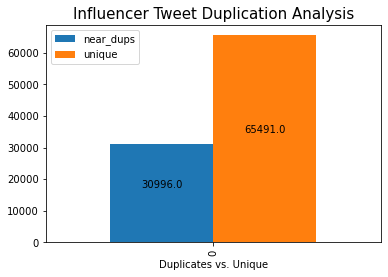

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Influencer Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 